# Imports

In [1]:
import shapefile

import geometry as gm
import map_projection as mp
import nav_graph as ng
import navigation as nav
import shape_helper as sh
import renderer as rd

# Set up navigation graph

In [2]:
TRANSPORT_DIR = 'data/VMTRANS2/'
sf = shapefile.Reader(TRANSPORT_DIR + 'TR_ROAD')
asrs = sh.all_srs(sf)

In [3]:
ngraph = ng.NavGraph(asrs)

In [4]:
def geom_length_attr_fn(graph, srs):
    gids = [graph.edges[e]['gid'] for e in graph.edges]
    return [gm.geom_length(sh.get_geom(srs[g])) for g in gids]

In [5]:
ngraph.set_edge_attributes(geom_length_attr_fn, 'gl')

# Query based on latitude and longitude

In [6]:
def projected_nearest_node(ngraph, lat, lng):
    pos = mp.web2vic(lat, lng)
    return ngraph.nearest_node(pos)

In [7]:
test_node = projected_nearest_node(ngraph, -37.7, 144.9)
end_node = projected_nearest_node(ngraph, -37.85, 147.51)
test_node

1714266

In [8]:
test_node_pos = ngraph.node_position(test_node)
mp.vic2web(test_node_pos[0], test_node_pos[0])

(-37.07925823033142, 144.90102788241902)

# Determine a route

In [9]:
np_hops = ngraph.shortest_path(test_node, end_node)
np_gl = ngraph.shortest_path(test_node, end_node, weight='gl')

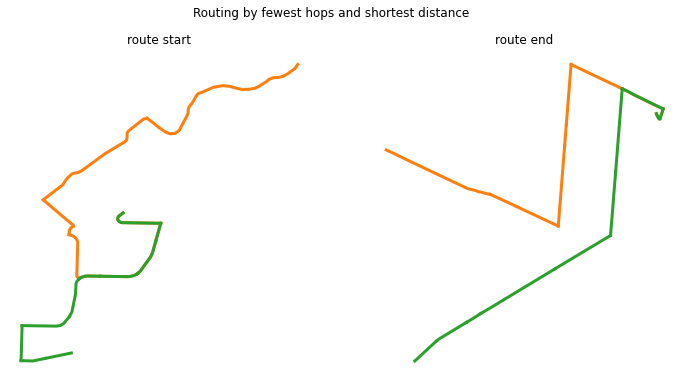

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(6)
fig.set_facecolor('w')

rd.draw_path_geoms(ax[0], np_hops, limit=10, color='tab:orange')
rd.draw_path_geoms(ax[0], np_gl, limit=10, color='tab:green')
rd.draw_path_geoms(ax[1], np_hops, limit=10, from_start=False, color='tab:orange')
rd.draw_path_geoms(ax[1], np_gl, limit=10, from_start=False, color='tab:green')

ax[0].axis('off')
ax[0].set_title('route start')
ax[1].axis('off')
ax[1].set_title('route end')
plt.suptitle('Routing by fewest hops and shortest distance')
plt.show()

# Generate navigation directions

Instructions for each segment in the graph

In [11]:
ni = nav.navigation_instructions(np_gl)
nav.navigation_summary(ni)

('Holly Court', 'Unnamed', 279314.50789562304, 1041)

In [12]:
ni[:10]

[('depart', -2.3405704638807445, 'Holly Court'),
 ('continue', 186.25253892109572, 'Holly Court'),
 ('pivot', 1.7623817810594518, 'Marigold Crescent'),
 ('continue', 80.10475300594481, 'Marigold Crescent'),
 ('pivot', 2.171540959958351e-05, 'Marigold Crescent'),
 ('continue', 155.00433298946166, 'Marigold Crescent'),
 ('pivot', -0.00035334564162883115, 'Marigold Crescent'),
 ('continue', 128.1847361157748, 'Marigold Crescent'),
 ('pivot', 0.003427468287840862, 'Gowanbrae Drive'),
 ('continue', 72.85327902012193, 'Gowanbrae Drive')]

Consolidating turn instructions when directions redundant

In [13]:
nc = nav.consolidated_instructions(ni)
nav.navigation_summary(nc)

('Holly Court', 'Unnamed', 279314.5078956232, 119)

In [14]:
nc[:10]

[('depart', -2.3405704638807445, 'Holly Court'),
 ('continue', 186.25253892109572, 'Holly Court'),
 ('pivot', 1.7623817810594518, 'Marigold Crescent'),
 ('continue', 363.29382211118127, 'Marigold Crescent'),
 ('pivot', 0.003427468287840862, 'Gowanbrae Drive'),
 ('continue', 422.570880141393, 'Gowanbrae Drive'),
 ('pivot', -1.570719584994123, 'Gowanbrae Drive'),
 ('continue', 152.40928186185644, 'Gowanbrae Drive'),
 ('pivot', -1.565509439345379, 'Lanark Way'),
 ('continue', 173.53287241766856, 'Lanark Way')]

Natural language instructions

In [15]:
def natural_instructions(steps):
    natural = [f'travel {nav.compass_description(steps[0][1])} on {steps[0][2]}']
    for i in range(len(steps) // 2 - 1):
        c = steps[2 * i + 1]
        p = steps[2 * i + 2]
        natural.append(f'continue for {nav.significant_distance(c[1])}m on {c[2]}')
        natural.append(f'{nav.turn_description(p[1])} into {p[2]}')    
    c = steps[-2]
    natural.append(f'continue for {nav.significant_distance(c[1])}m on {c[2]}')
    natural.append(f'arrive on {steps[-1][2]}')
    return natural

In [16]:
nn = natural_instructions(nc)

In [17]:
nn[:10]

['travel south west on Holly Court',
 'continue for 190m on Holly Court',
 'turn right into Marigold Crescent',
 'continue for 360m on Marigold Crescent',
 'go straight into Gowanbrae Drive',
 'continue for 420m on Gowanbrae Drive',
 'turn left into Gowanbrae Drive',
 'continue for 150m on Gowanbrae Drive',
 'turn left into Lanark Way',
 'continue for 170m on Lanark Way']